# Getting Started with Medical Imaging

In this tutorial, we will be looking at how to work with Medical Imaging samples in FiftyOne. We will specifically looking at DICOM files and CT scan files! While there are a few known variations on how they can be store, the pattern is the same.

Note, we will not be covering how to load medical images that are normally stored as `.jpg` or `.png` . Please refer to the quickstart if you are working with normal images!

## Installation
Some new libraries are required to load the data

In [10]:
!pip install pydicom==2.4.4 rt_utils kagglehub nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.3 MB/s eta 0:00:00a 0:00:01


## Downloading DICOM Dataset

First let's grab some example DICOM files. Below is a [great demo dataset](https://www.kaggle.com/datasets/aryashah2k/hippocampal-sparing-dataset) from Kaggle. It is not of the highest quality, but it works well for beginners. Inside it, we have 25 brain scans of paitents with annotations of their left and right hippocampus stored in `.dcm` files. Lets begin by downloading the dataset:

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/hippocampal-sparing-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1


## Loading DICOM Files

FiftyOne features a [DICOM dataset loader](https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#dicomdataset) that we will be taking advantage of here. This will load our `.dcm` files in as 2D slices that we can then play as a video once its all loaded. 

An important note here is the use of `dicom_path`. In our dataset we have MR dicoms and RS dicoms, with the former being the scan and the latter being the annotations. We only want to load the scan as our base sample and load the annotations on later. FiftyOne is very flexible with how you load and present data, so feel free to dive more into the [dataset loader](https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#dicomdataset) to get the best experience for you!

Let's begin loading a single patient's data below. Check out the comments to find out what is happening at each step!

In [ ]:
import fiftyone as fo
import glob
from rt_utils import RTStructBuilder
import numpy as np
import cv2
import os


# Path to the dataset
dataset_dir = path + "/HippocampalMRISlices/01/"

# Create the dataset
dataset = fo.Dataset.from_dir(
    dataset_dir=dataset_dir,
    dataset_type=fo.types.DICOMDataset,
    dicom_path="MR*.dcm",
    name="Patient1Scans",
)

# Load RTStruct for labels
rtstruct_path = glob.glob(dataset_dir + "RS*.dcm", recursive=True)
rtstruct = RTStructBuilder.create_from(dicom_series_path=dataset_dir, rt_struct_path=rtstruct_path[0])

# Get structure names
structures = rtstruct.get_roi_names()
print("Structures in RTStruct:", structures)

# Get mask for each structure
L_mask3d = rtstruct.get_roi_mask_by_name(structures[0])
R_mask3d = rtstruct.get_roi_mask_by_name(structures[1])

# Sort dataset from bottom to top of the scan
view = dataset.sort_by("SliceLocation")

# Add masks to the dataset
i = 0
for sample in view:

    # Load left Hippocampus mask
    sample["Hippocampus_L"] = fo.Segmentation(mask=L_mask3d[:,:,i].astype(np.uint8))

    # Load right Hippocampus mask
    sample["Hippocampus_R"] = fo.Segmentation(mask=R_mask3d[:,:,i].astype(np.uint8))
    i = i + 1
    sample.save()

No `images_dir` provided. Images will be unpacked to '/Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1/HippocampalMRISlices/01'
   0% ||----------------|   1/276 [188.0ms elapsed, 51.7s remaining, 5.3 samples/s] 

/Users/dangural/anaconda3/envs/OSS310/lib/python3.10/site-packages/fiftyone/utils/dicom.py:100: UserWarning: Ignoring field 'DeidentificationMethodCodeSequence' with unsupported type <class 'pydicom.sequence.Sequence'>
  warnings.warn(msg)


 100% |█████████████████| 276/276 [683.8ms elapsed, 0s remaining, 404.1 samples/s]      
Structures in RTStruct: ['Hippocampus_L', 'Hippocampus_R']


Afterwards we can open up our app to see patient 1's scan and segmentation! Right away you might notice that we are only looking at individual slices. If we want to watch the playback of these, we need to use dynamic grouping! [LINK] 

To dynamicly group our dataset, click the dynamic group button above the grid that looks like two merging arrows. We want to group by `Patient ID` and order by `SliceLocation`. This should present now just one sample in the grid. Lastly, click the gear icon and check "Render frames as video". Below is a video showing how to do the above as well


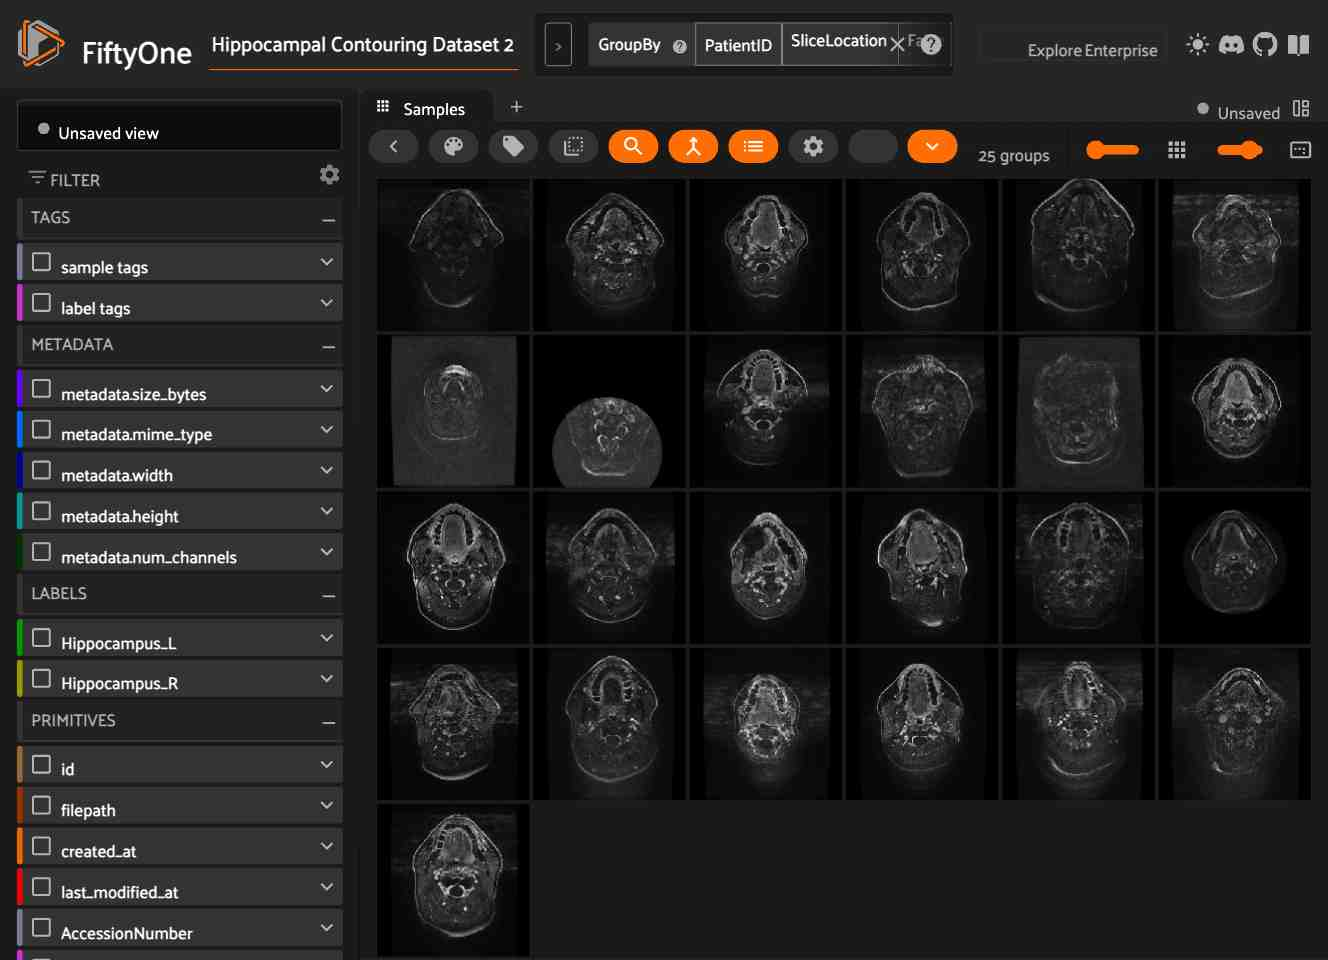

In [4]:
session = fo.launch_app(dataset)

![patient1_slices](./assets/patient1_slices.webp)

## Automatic Metadata Ingestion

One of the other awesome features of the DICOM Dataset Loader is that it will automatically grab all the meta data from our `.dcm` file for us! Scan the sidebar in the app to search, filter and sort across fields like `BodyPartExamined`, `Manufacturer`, `SliceLocation` and more!

But to get a full picture, we should load in the other 24 patients! To do this we will follow the same pattern above we did for Patient 1 and the use `merge_sample` [LINK] in order to combine datasets into one final dataset for us!

In [ ]:
# Get a list of all directories in the dataset
directories = [d for d in os.listdir(path + "/HippocampalMRISlices/") if os.path.isdir(os.path.join(path + "/HippocampalMRISlices/", d))]

# Create a new dataset to merge all the datasets
final_dataset = fo.Dataset("Hippocampal Contouring Dataset 2")

# Loop through all directories
for directory in directories:
    dataset_dir = path + "/HippocampalMRISlices/" + directory + "/"

    # Create the dataset
    dataset = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=fo.types.DICOMDataset,
        dicom_path="MR*.dcm"
    )

    # Load RTStruct for labels
    rtstruct_path = glob.glob(dataset_dir + "RS*.dcm", recursive=True)
    rtstruct = RTStructBuilder.create_from(dicom_series_path=dataset_dir, rt_struct_path=rtstruct_path[0])

    # Get structure names
    structures = rtstruct.get_roi_names()

    # Get mask for each structure
    L_mask3d = rtstruct.get_roi_mask_by_name(structures[0])
    R_mask3d = rtstruct.get_roi_mask_by_name(structures[1])

    # Sort dataset from bottom to top of the scan
    view = dataset.sort_by("SliceLocation")

    i = 0
    for sample in view:

        # Load left Hippocampus mask
        sample["Hippocampus_L"] = fo.Segmentation(mask=L_mask3d[:,:,i].astype(np.uint8))

        # Load right Hippocampus mask
        sample["Hippocampus_R"] = fo.Segmentation(mask=R_mask3d[:,:,i].astype(np.uint8))
        i = i + 1
        sample.save()
    
    # Merge the dataset with the final dataset
    final_dataset.merge_samples(dataset)

No `images_dir` provided. Images will be unpacked to '/Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1/HippocampalMRISlices/03'
 100% |█████████████████| 392/392 [908.4ms elapsed, 0s remaining, 432.0 samples/s]      
No `images_dir` provided. Images will be unpacked to '/Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1/HippocampalMRISlices/04'
 100% |█████████████████| 332/332 [691.5ms elapsed, 0s remaining, 480.7 samples/s]      
No `images_dir` provided. Images will be unpacked to '/Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1/HippocampalMRISlices/05'
 100% |█████████████████| 292/292 [634.3ms elapsed, 0s remaining, 460.9 samples/s]      
No `images_dir` provided. Images will be unpacked to '/Users/dangural/.cache/kagglehub/datasets/aryashah2k/hippocampal-sparing-dataset/versions/1/HippocampalMRISlices/02'
 100% |█████████████████| 292/292 [684.2ms elapse

Now we have all the patients into a single dataset, we can change our app to view our current dataset! Try dynamic grouping to see all of our different scans in our dataset as videos!

In [ ]:
session.dataset = final_dataset

![all_slices](./assets/all_slices.webp)

## Working with CT Scans
In FiftyOne, working with CT Scans can be a bit more tricky. CT Scans can come in multiple different file formats that all have slight variations. In order to ingest these files, we need to manually slice them ourselves. The main file formats used for CT scans are DICOM (`.dcm`), NIfTI (`.nii` or `nii.gz`), NRRD (`.nrrd`), or occasionally MHA/MHD (`.mha`, `.mhd` + `.raw`). 

The good new is if it is stored in DICOM format, you can follow the instructions above! If it is one of the other formats, we need to define what are base atomic sample is and store that as image. This means loading a NIfTI file for example, defining the slice in python, and then saving it back with `opencv` or a similar tool. We will show an example below using NIfTI files with masks.

Note, there are ongoing community efforts to bring in 3D visualizers for Medical Imaging to better support DICOM, NIfTI, NRRD, and more! If you are interested in testing out experimental tools or contributing yourself, checkout the work at our Discord [LINK]!

## Downloading the CT Scan Data
We will be using another [demo dataset from kaggle](https://www.kaggle.com/datasets/andrewmvd/covid19-ct-scans?select=ct_scans) that captures some COVID-19 lung scans! Download using the code below:


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/covid19-ct-scans")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:24<00:00, 44.7MB/s]

Extracting files...


Path to dataset files: /Users/dangural/.cache/kagglehub/datasets/andrewmvd/covid19-ct-scans/versions/4


Now with our data downloaded, just like before lets first begin with just a single patient scan.

In [38]:
import nibabel as nib
import numpy as np
import os
import cv2
import fiftyone as fo

## Loading NIfTI Files in FiftyOne
We are going to define some helper functions to handle to loading of the NIfTI files. This time around, we will take a different approach to working with medical images. Instead of saving each individual slice like before, we will instead save an `mp4` of all the slices. This will be memory efficient and easy for us to slice and search through.

In our first helper function, `nii_to_mp4`, we will take in a `.nii` file from our CT scan and save it back as an mp4 in the axial view. 

In [ ]:
def nii_to_mp4(filepath, fps=30):
    '''
    Reads .nii file and returns pixel array
    '''
    # Load .nii file
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()

    # Rotate array
    array   = np.rot90(np.array(array))

    # Normalize pixel values
    array = (array - np.min(array)) / (np.max(array) - np.min(array)) * 255
    array = array.astype(np.uint8)

    # Define video writer
    height, width, depth = array.shape
    output_path = filepath.replace(".nii", ".mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=True)

    # Write each axial slice to the video
    for i in range(depth):
        frame = array[:, :, i]
        # Convert grayscale to BGR for consistent writing
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        video_writer.write(frame_bgr)

    video_writer.release()
    return(output_path)

In our next helper function, `read_nii`, we load in a `.nii` file like before, but this time instead we are going to return the array to be loaded onto our samples as a Segmentation mask! [LINK]

In [54]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    array = array.astype(np.uint8)  
    return(array)

With our helper functions, we can grab our first sample and attempt to load it in! Dont forget we need the 3 different segmentation masks as well.

In [77]:
# Convert Scan to mp4
sample_ct   = nii_to_mp4(path + "/ct_scans/coronacases_org_001.nii")

# Read the masks
sample_lung = read_nii(path + "/lung_mask/coronacases_001.nii")
sample_infe = read_nii(path + "/infection_mask/coronacases_001.nii")
sample_all  = read_nii(path + "/lung_and_infection_mask/coronacases_001.nii")

Next we create a FiftyOne sample. Since we passed in a `.mp4` file, this will be a video sample [LINK]. With video samples, we can store any type of label on each frame. Let's try loading our segmentation masks on each slice of our CT scan!

If you want to learn more about how to work with FiftyOne video samples and datasets, check out Getting Started with Videos! [LINK]

In [ ]:
# Create output folder
sample = fo.Sample(filepath=sample_ct)


for i in range(sample_lung.shape[2]):

    # Add masks to each frame. Note that video frames start from 1, there is no frame 0!
    sample.frames[i+1]["Infection Mask"] = fo.Segmentation(mask=sample_infe[:, :, i].astype(np.uint8))
    sample.frames[i+1]["Lung Mask"] = fo.Segmentation(mask=sample_lung[:, :, i].astype(np.uint8))
    sample.frames[i+1]["All Masks"] = fo.Segmentation(mask=sample_all[:, :, i].astype(np.uint8))


With our video sample created and annotations added, we can create a dataset to load into. The final step is to make sure that the `.mp4` we saved can be rendered in all browsers. Not all `mp4`s are encoded the same, so we use `fo.utils.video.reencode_videos()` to ensure that it will render for us in the app! Speaking of which, after it is reencoded, lets open up the app and look at our first scan!

In [ ]:
# Create a dataset of Patient 1
dataset = fo.Dataset(name="COVID-19 CT Scans Patient 1", overwrite=True)
dataset.add_samples([sample])

# Reencode videos so it will play in any browser
fo.utils.video.reencode_videos(dataset)

# Launch the App
session = fo.launch_app(dataset)

 100% |█████████████████████| 1/1 [1.4s elapsed, 0s remaining, 0.7 samples/s] 
 100% |█████████████████████| 1/1 [368.8ms elapsed, 0s remaining, 2.7 samples/s] 


![patient1_ct1](./assets/patient1_ct.webp)

Great! Now we can visualize our first CT Scan. Try different color options by clicking the color palatte button above the grid and change "Color annotations by" to `value`.

Next step is to repeat the same process for our annotations as well and add them to our sample!

In [91]:
# List all files in the directory that end with .nii
ct_scan_files = [f for f in os.listdir(path + "/ct_scans/") if f.endswith(".nii") and os.path.isfile(os.path.join(path + "/ct_scans/", f))]
ct_scan_files.sort()
print(ct_scan_files[0])

lung_files = [f for f in os.listdir(path + "/lung_mask/") if f.endswith(".nii") and os.path.isfile(os.path.join(path + "/lung_mask/", f))]
lung_files.sort()
print(lung_files[0])

infe_files = [f for f in os.listdir(path + "/infection_mask/") if f.endswith(".nii") and os.path.isfile(os.path.join(path + "/infection_mask/", f))]
infe_files.sort()
print(infe_files[0])

all_files = [f for f in os.listdir(path + "/lung_and_infection_mask/") if f.endswith(".nii") and os.path.isfile(os.path.join(path + "/lung_and_infection_mask/", f))]
all_files.sort()
print(all_files[0])

coronacases_org_001.nii
coronacases_001.nii
coronacases_001.nii
coronacases_001.nii


We have all of our scans sorted and in a list, it is now time to loop over them and create some samples! 

This pattern of creating samples, appending them to a list, and the adding them to a FiftyOne dataset is one of the fastest ways to create a FiftyOne dataset in terms of time complexity. This is because it minimizes the number of writes to your backend database. Try using it anytime you are loading large number of samples to cut down the load times!

In [92]:
samples = []
for i in range(len(ct_scan_files)):
    # Convert Scan to mp4
    sample_ct   = nii_to_mp4(path + "/ct_scans/" + ct_scan_files[i])

    # Read the masks
    sample_lung = read_nii(path + "/lung_mask/" + lung_files[i])
    sample_infe = read_nii(path + "/infection_mask/" + infe_files[i])
    sample_all  = read_nii(path + "/lung_and_infection_mask/" + all_files[i])

    # Create Sample
    sample = fo.Sample(filepath=sample_ct)

    for i in range(sample_lung.shape[2]):

        # Add masks to each frame
        sample.frames[i+1]["Infection Mask"] = fo.Segmentation(mask=sample_infe[:, :, i].astype(np.uint8))
        sample.frames[i+1]["Lung Mask"] = fo.Segmentation(mask=sample_lung[:, :, i].astype(np.uint8))
        sample.frames[i+1]["All Masks"] = fo.Segmentation(mask=sample_all[:, :, i].astype(np.uint8))
    
    samples.append(sample)

# Create a dataset of all Patients
dataset = fo.Dataset(name="COVID-19 CT Scans", overwrite=True)
dataset.add_samples(samples)

# Reencode videos so it will play in any browser
fo.utils.video.reencode_videos(dataset)

# Launch the App
session = fo.launch_app(dataset)

 100% |███████████████████| 20/20 [20.8s elapsed, 0s remaining, 1.2 samples/s]      
 100% |███████████████████| 20/20 [6.2s elapsed, 0s remaining, 2.9 samples/s]      


After running the above code, you should be able to visualize all the scans in the dataset now!

![all_scans](./assets/all_patients_ct.webp)

Next up, try checking out some of our other docs to take your Medical Imaging dataset to next level by utilitzing tools like:
- Visualizing Embeddings
- Similarity Search
- MedSAM2 in Model Zoo

and more! [LINKS]